# Captcha challenge using Fine-Tuning


#### Welcome to this guided white-box captcha solving challenge, during this notebook you will learn how to create your own custom OCR, which can be reused and modified according to the problem. The concepts discussed and used do not require any mathematical background, so you are free to explore them further. 

## Table of Contents
1. [DATASET GENERATION](#1)
2. [MODEL IMPLEMENTATION](#2)
3. [DATA LOADING AND DATA PREPROCESSING](#3)
4. [TRAINING](#4)
5. [INFERENCE IMAGE BY IMAGE](#5)
6. [INFERENCE ON CAPTCHAS](#6)




### Requirements

In [1]:
!python3 -m pip install numpy torch Pillow matplotlib requests transformers

Python est introuvable. Ex�cutez sans argument pour proc�der � l


**Attention! The captcha becomes invalid after a few seconds! If your machine takes too long to make computations, switch to a google collab :)**

# DATASET GENERATION
<a id="1"></a>

For image classification tasks, dataset labelling involves classifying each image into predefined categories. This organisation allows the machine learning model to learn the distinct characteristics of each category during training. 

First, we need to import the necessary libraries:

In [2]:
import os
from utils.image import choose_random_position
from helpers.image_generator import ImageGenerator
import random
from PIL import ImageFont, Image

Next, we set up the parameters for generating the images, each parameter applies a modification to the image. 

Here are the parameters used on the server side, **you can play with it, but you'll generate different captchas** from the web server, at your own risk then ;)

In [3]:
folder_fonts = "ttf"
font_paths = [os.path.join(folder_fonts, f) for f in os.listdir(folder_fonts)]

charset="ʕʊɮƩƟƋƿӁҦϸ˄ʬᾳ"
height = 160
width = 160
font_path = random.choice(font_paths)
font_size = random.randint(100, 150)
font = ImageFont.truetype(font_path, font_size)
char_color = (random.randint(0, 180), random.randint(0, 180), random.randint(0, 180))
background_color = (255, 255, 255)
noise_level = 120
blur_level = 2
perspective_angle = random.uniform(-5, 5)
rotation_angle = random.uniform(-30, 30)


char = charset[3] # First label, for the exemple
position = choose_random_position(height, width, char, font)
char_x = position[0]
char_y = position[1]

Then use these parameters to generate the image of a single character, using the white-box function **ImageGenerator()** ( there is no need to audit it for the challenge ) 

In [4]:
my_generator = ImageGenerator(height=height, width=width)

img = my_generator( char,
                    char_x=char_x,
                    char_y=char_y,
                    char_color=char_color, 
                    font=font, 
                    background_color=background_color,
                    blur_level=blur_level,
                    rotation_angle=rotation_angle,
                    perspective_angle=perspective_angle,
                    noise_level=noise_level)

You should obtain an image similar to the captcha format :

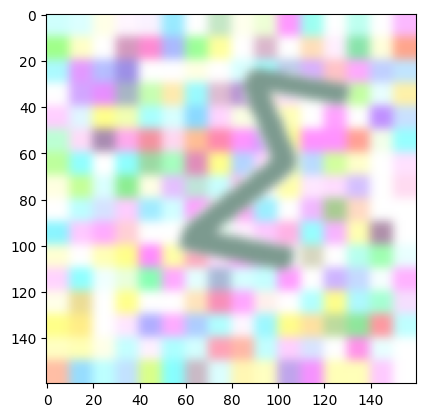

In [5]:
import matplotlib.pyplot as plt

plt.imshow(img)
plt.axis('on')
plt.show()

Now it's time to generate a dataset of several different labelled images for each charset character

To do this, reuse the code above, and create a few hundred images ( 500 for exemple ) to train the model, the goal being to obtain this kind of folder 


```raw
    dataset/
        0/
            1.png
            2.png
            3.png
            ...
        1/
            1.png
            2.png
            3.png
            ...
        2/
            ...
            ...
```

In [8]:
def generate_images_dataset(dataset_folder, charset, n_images_per_char=20):
    for _char in charset:
        for n in range(n_images_per_char):
            #Random Init
            char_color = (random.randint(0, 180), random.randint(0, 180), random.randint(0, 180))
            perspective_angle = random.uniform(-5, 5)
            rotation_angle = random.uniform(-30, 30)

            position = choose_random_position(height, width, _char, font)
            char_x = position[0]
            char_y = position[1]

            img = my_generator( _char,
                    char_x=char_x,
                    char_y=char_y,
                    char_color=char_color, 
                    font=font, 
                    background_color=background_color,
                    blur_level=blur_level,
                    rotation_angle=rotation_angle,
                    perspective_angle=perspective_angle,
                    noise_level=noise_level)
            
            img.save(dataset_folder + "/" + _char + str(n + 1) + ".png")
        
generate_images_dataset("imgfolder", charset)

## **MODEL IMPLEMENTATION**
<a id="2"></a>

Now that the training images have been generated through *generate_images_dataset* function, let's create a classifier and train it.

To do this, we will fine-tune the head classifier of [MobileNet V2](https://pytorch.org/hub/pytorch_vision_mobilenet_v2/). 

This model will serve as the base of our new model, allowing us to leverage the features it has learned from a large dataset. We will add additional layers on top of this base model to fine-tune it for our specific task

First, let's load the pretrained model:

In [30]:
from transformers import AutoImageProcessor, MobileNetV2ForImageClassification

image_processor = AutoImageProcessor.from_pretrained("google/mobilenet_v2_1.0_224") # This is explained later
model = MobileNetV2ForImageClassification.from_pretrained("google/mobilenet_v2_1.0_224")

preprocessor_config.json:   0%|          | 0.00/406 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/69.8k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/14.2M [00:00<?, ?B/s]

In [31]:
print(model.classifier)

Linear(in_features=1280, out_features=1001, bias=True)


This function displays the last layer of the model, with its associated number of nodes. Though the attribute is named *classifier*, it is not really one: it does not end with a Softmax or Sigmoid activation, which are usually used as a classification function

If we take the technical characteristics of the [MobileNet V2](https://pytorch.org/hub/pytorch_vision_mobilenet_v2/) model, we can see that the last layer is in fact a conv2d. Our current model is therefore not adapted to our problem, which requires a **classification of 13 classes**, so we need to modify it. 

Hence, we need to adapt it to our classification problem. **This is where fine-tuning comes in**. We need to modify the classification layers add functions to complete our original model

Now, make a basic architecture based on the Dropout, Linear, ReLU, Softmax, and BatchNorm1d torch.nn classes for the classifier.

In [32]:
from torch.nn import Dropout, Linear, Sequential, ReLU, Softmax, BatchNorm1d

n_classes = ... # TODO

model.classifier = Sequential( # Overwrite the current classifier
    Linear(in_features=1280, out_features=512, bias=True), # A little help here :)
    Dropout.
)

TypeError: ellipsis is not a Module subclass

Feel free to experiment different architecture, there's fundamentally no expected response. **But try to finish the tutorial once and come back to this part later depending on the results**.

Next, we only want to train our new architecture. To do this, we can freeze the layers not concerned by using the **requires_grad** function.

In [33]:
# Freeze backbone
for param in model.mobilenet_v2.parameters():
    param.requires_grad = False

for param in model.mobilenet_v2.conv_1x1.parameters():
    param.requires_grad = True

for param in model.classifier.parameters():
    param.requires_grad = True

Finally, we put our model into training mode 

In [34]:
import torch 

device = torch.device("cuda" if torch.cuda.is_available() else "cpu") # Use GPU if available, it doesn't matter if you use cpu for this task
model.to(device)

model.train() # We're ready ! 

MobileNetV2ForImageClassification(
  (mobilenet_v2): MobileNetV2Model(
    (conv_stem): MobileNetV2Stem(
      (first_conv): MobileNetV2ConvLayer(
        (convolution): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False)
        (normalization): BatchNorm2d(32, eps=0.001, momentum=0.997, affine=True, track_running_stats=True)
        (activation): ReLU6()
      )
      (conv_3x3): MobileNetV2ConvLayer(
        (convolution): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), groups=32, bias=False)
        (normalization): BatchNorm2d(32, eps=0.001, momentum=0.997, affine=True, track_running_stats=True)
        (activation): ReLU6()
      )
      (reduce_1x1): MobileNetV2ConvLayer(
        (convolution): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (normalization): BatchNorm2d(16, eps=0.001, momentum=0.997, affine=True, track_running_stats=True)
      )
    )
    (layer): ModuleList(
      (0): MobileNetV2InvertedResidual(
        (expand_1x1): MobileNe

## **DATA LOADING AND DATA PREPROCESSING**
<a id="3"></a>

As you may have noticed, we instanciated an image processor object called *image_processor* along with the model.

Both the model and the preprocessor are built using *from_pretrained* method, which is a good practice to ensure their compatibility.
Before starting the training, we need to load the previously generated images and to standardize them.

To do it in a proper way, let's implement a *torch.utils.data.Dataset* inherited class we will name *CustomImageDataset*.

You will be in charge of implementing the *__getitem__* method that returns the idx<sup>th</sup> image dataset <u>after standardization</u> and its corresponding label.

Note: The label should be a One-Hot-Encoded vector (see https://pytorch.org/docs/stable/generated/torch.nn.functional.one_hot.html)

In [35]:
import os
from torch.utils.data import Dataset

class CustomImageDataset(Dataset):
    def __init__(self, folder_data, limit=None):
        self.data_folder = folder_data
        self.labels_unique = [int(label) for label in os.listdir(folder_data)]
        self.paths_img = []
        self.labels = []
        for label in self.labels_unique:
            folder_label = os.path.join(folder_data, str(label))
            new_paths = [os.path.join(folder_label, f) for f in os.listdir(folder_label)]
            new_labels = [label for _ in range(len(new_paths))]
            self.paths_img.extend(new_paths)
            self.labels.extend(new_labels)
        if limit:
            self.paths_img = self.paths_img[:limit]
            self.labels = self.labels[:limit]

    def __len__(self):
        return len(self.labels)
    
    @staticmethod
    def preprocess(image):
        # https://pytorch.org/hub/pytorch_vision_mobilenet_v2/
        raise NotImplementedError
        
    
    def __getitem__(self, idx):
        img_path = self.paths_img[idx]
        image = Image.open(img_path)
        image_processed = self.preprocess(image)
        label = ... # TODO
        return image_processed, label

Now, let's load the images using our *CustomImageDataset* object, and wrap the dataset with torch.utils.data.DataLoader to easily iterate
over batches of images.

You can create a new validation dataset on which the model will perform validations on data that is not used during training. This will allow you to check that the model is correctly adapting to the problem.

In [37]:
from torch.utils.data import DataLoader

train_folder = "train" # TODO
batch_size_train = 40 # large batch == more ram needed
train_dataset = CustomImageDataset(train_folder, limit=None)
train_loader = DataLoader(train_dataset, batch_size=batch_size_train, shuffle=True)

# optional
validation_folder = ""
if validation_folder:
    validation_dataset = CustomImageDataset(validation_folder, limit=None)
    n_validation = len(validation_dataset)
    validation_loader = DataLoader(validation_dataset, batch_size=n_validation, shuffle=False)

ValueError: num_samples should be a positive integer value, but got num_samples=0

You can display a sample to visually check the formatting of the data

In [ ]:
import matplotlib.pyplot as plt

data_iter = iter(train_loader)
images, labels = next(data_iter)

# Convert tensors to numpy arrays for display
images_np = images.permute(0, 2, 3, 1).numpy()
images_np = (images_np - images_np.min()) / (images_np.max() - images_np.min())

# Create a mapping from one-hot encoded labels to class indices
class_indices = torch.argmax(labels, dim=1).numpy()

fig, axes = plt.subplots(1, 5, figsize=(15, 5))
for i, ax in enumerate(axes):
    print(f"Test {i} : {labels[i]}")
    ax.imshow(images_np[i])
    ax.set_title(f"Class: {class_indices[i]}")
    ax.axis('off')
plt.show()

## **TRAINING**
<a id="4"></a>

Next, let's define:
- The loss function, or *criterion*: categorical crossentropy (see https://pytorch.org/docs/stable/generated/torch.nn.CrossEntropyLoss.html)
- The optimizer, to be selected among those implemented in torch.nn.optim (https://pytorch.org/docs/stable/optim.html)

In [ ]:
optimizer = ... # TODO
criterion = ... # TODO

Feel free to experiment different optimizers, learning rates or any other hyperparameters, there's fundamentally no expected response.

You are now ready to implement the core part of the training ! The model weights are iteratively updated *num_epochs* times.
Again, experiment as much as needed: you can change *num_epochs* default value, try different head classifier architectures, add extras components to the training if these are helpful.

It is important to note that you will not be able to tend your loss towards 0. To evaluate training, make sure that your loss drops during the first epochs and then use accuracy.

Notes:
1) A very useful tool to track and compare experiments is MLFlow (see https://mlflow.org/docs/latest/tracking.html).
2) A good practice is generally to specify all the training parameters (batch size, number of epochs, learning rate ...) in a *config.yaml* file ; )

In [ ]:
num_epochs = 5
log_interval = 1 # display logs every batch

# Will be used for plot :)
train_losses = []
train_accuracies = []
val_losses = []
val_accuracies = []

for epoch in range(num_epochs):
    loss_epoch = 0 # mean loss over the batches
    correct = 0 
    total = 0
    for batch_idx, (data, targets) in enumerate(train_loader):

      # TODO: ship inputs and outputs to device

      # TODO: zero the gradients
      
      # TODO: perform forward pass

      outputs = model(data).logits # Used for compute accuracy

      loss = ... # TODO: compute the loss value
      loss_epoch += loss.item()

      _, predicted = torch.max(outputs, 1)
      total += targets.size(0)
      correct += (predicted == targets.argmax(dim=1)).sum().item() # Used for compute accuracy
      
      # TODO: perform backward pass
      
      # TODO: update model parameters
      
      # Print training progress 
      if batch_idx % log_interval==0:
        print(f"Epoch {epoch+1}/{num_epochs} | Batch {batch_idx}/{len(train_loader)} | Loss: {loss.item():.4f}")
    
    avg_loss = loss_epoch / len(train_loader)
    accuracy = correct / total

    train_losses.append(loss_epoch)
    train_accuracies.append(accuracy)

    print(f"Epoch {epoch+1} finished | Avg Loss: {avg_loss:.4f} | Avg Accuracy: {accuracy:.4f}")




    # Compute validation loss if validation set available
    if validation_folder:

      with torch.no_grad():
        for data, targets in validation_loader:

          # Use the same logic than for the train

          loss_validation = ... # TODO

          _, predicted = torch.max(outputs, 1)
          total += targets.size(0)
          correct += (predicted == targets.argmax(dim=1)).sum().item()

      
      avg_val_loss = loss_validation / len(validation_loader)
      val_accuracy = correct / total
      val_losses.append(avg_val_loss)
      val_accuracies.append(val_accuracy)
      print(f"Epoch {epoch+1}/{num_epochs} | Validation Loss: {loss_validation.item():.4f} | Validation Accuracy: {val_accuracy:.4f}")

You can plot your results below 

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Training Loss')
if validation_folder:
    plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss Curve')
plt.legend()


plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Training Accuracy')
if validation_folder:
    plt.plot(val_accuracies, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy Curve')
plt.legend()

plt.show()

Finally, if the training has been successful, save the model as a *pt* file !

In [ ]:
torch.save(model, "trained_model.pt")

The fine-tuned MobileNet is now ready to decrypt the captchas.

## **INFERENCE IMAGE BY IMAGE**
<a id="5"></a>

First thing first, let's try to infer (predict) the label of a single image. 

To begin with, let's reload our trained model

In [ ]:
model = torch.load("trained_model.pt")

In [ ]:
# TODO: set model to the appropriate mode, no model.train() this time ...

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

Once the model is loaded, import your image and make a prediction using https://pytorch.org/docs/stable/generated/torch.argmax.html.

Don't forget to ship the image to the device as well.

In [ ]:
def preprocess_image():
    raise NotImplementedError # TODO


image = ...
image_preprocessed = ...

# Infer without storing gradients for backward propagation, same thing that the validation dataset process during the train
with torch.no_grad():
    logit = model(image_preprocessed).logits
    idx = ... # TODO: select the category index with highest probability
    label = ... # TODO: convert the index into label (i.e the charset)

## **INFERENCE ON CAPTCHAS**
<a id="6"></a>

Now, let's adapt the code above to handle captchas, i.e sequences of images !

Remember you have to submit the chain of symbols represented on the captcha, not the label indices, so there is an conversion to apply.

**Attention! The captcha becomes invalid after a few seconds! As mentioned above, if your machine takes too long to predict the results, switch to a google collab :)**

In [ ]:
import requests

def debug(img, prediction): # Plot results
        axes[i].imshow(img)
        axes[i].set_title(prediction)
        axes[i].axis('off')

def submit_captcha(predicted_captcha, uuid):
    verification_url = 'http://IP/verify'
    data = {
        'captcha': predicted_captcha,
        'uuid': uuid
    }
    print(requests.post(verification_url, data=data))



def split_captcha(img_captcha):
    raise NotImplementedError # TODO

def label_to_char(label):
    raise NotImplementedError # TODO

def request_captcha(url):
    # Return image + uuid
    raise NotImplementedError # TODO
    


# captcha processing
img_captcha = ...
seq_images = split_captcha(img_captcha)

# TODO: images processing
seq_labels = ...
seq_chars = [label_to_char(label) for label in seq_labels]
out = ... # TODO: turn list of chars into string of chars


submit_captcha(out, uuid) # FLAG !

# Well done for getting to the end
The first time you read this you probably won't get any convincing results, so don't be discouraged and go through the tutorial again step by step, and don't hesitate to take inspiration from fine tuning that already exists for other problems. 

Don't hesitate to propose your architecture as a solution, with a explanation of the choices you've made.

All the best and good luck with your next challenges!